In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
%matplotlib inline

from scipy.signal import argrelextrema
import seaborn as sns

from tqdm.notebook import tqdm
import os
import imageio

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'binary'

In [31]:
def simple_wave_packet(order: int, freq: list, ampl: list, phase0:list, betha: list):
    assert (len(freq) == order) & (len(ampl) == order) & (len(phase0) == order) & (len(betha) == order)
    
    wave_pack = 0
    for i in range(order):
        wave_pack += sin_wave(t, freq[i], ampl=[i], phase0=[i], betha=[i])
    return wave_pack

def sin_wave(t, freq, ampl=1, phase0=0, betha=None):
    wave = ampl * np.sin(2 * np.pi * freq * t + phase0)
    wave = wave if not betha else wave * np.exp(-betha)
    return wave

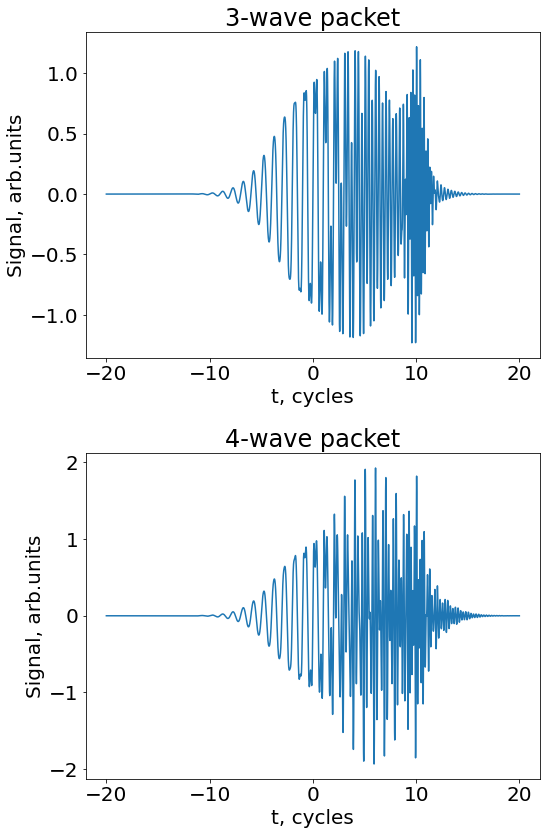

In [85]:
# t = np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14+5)
t = np.linspace(-20*2*np.pi, 20*2*np.pi, 3**9) 

y = np.sin(t) * np.exp(-t**2/2/20**2)
y = y + np.sin(3*t) * np.exp(-(t-5*2*np.pi)**2/2/20**2)
y = y + np.sin(5.5*t) * np.exp(-(t-10*2*np.pi)**2/2/5**2)
y_4 = y + np.sin(4*t) * np.exp(-(t-7*2*np.pi)**2/2/20**2)

fig, axes = plt.subplots(2, 1, figsize=(8, 12), squeeze=True)

axes[0].plot(t/2/np.pi, y)
axes[0].set_xlabel('t, cycles')
axes[0].set_ylabel('Signal, arb.units');
axes[0].set_title('3-wave packet')

axes[1].plot(t/2/np.pi, y_4)
axes[1].set_xlabel('t, cycles')
axes[1].set_ylabel('Signal, arb.units')
axes[1].set_title('4-wave packet')

plt.tight_layout();

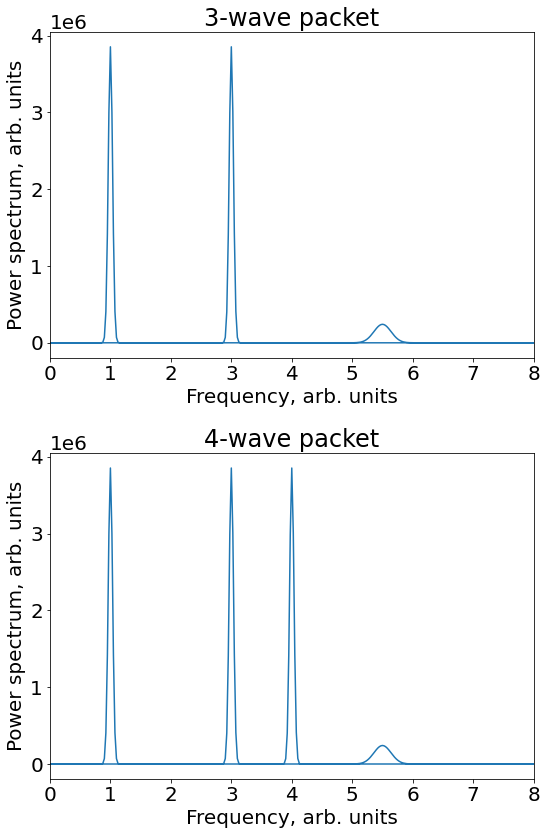

In [48]:
sp_3 = np.fft.fft(y)
sp_4 = np.fft.fft(y_4)
w = np.fft.fftfreq(len(y_4), d=(t[1]-t[0])/2/np.pi)

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

axes[0].plot(w, np.abs(sp_3)**2)
axes[0].set_xlim(0, 8)
axes[0].set_xlabel('Frequency, arb. units')
axes[0].set_ylabel('Power spectrum, arb. units')
axes[0].set_title('3-wave packet');

axes[1].plot(w, np.abs(sp_4)**2)
axes[1].set_xlim(0, 8)
axes[1].set_xlabel('Frequency, arb. units')
axes[1].set_ylabel('Power spectrum, arb. units')
axes[1].set_title('4-wave packet')

plt.tight_layout();

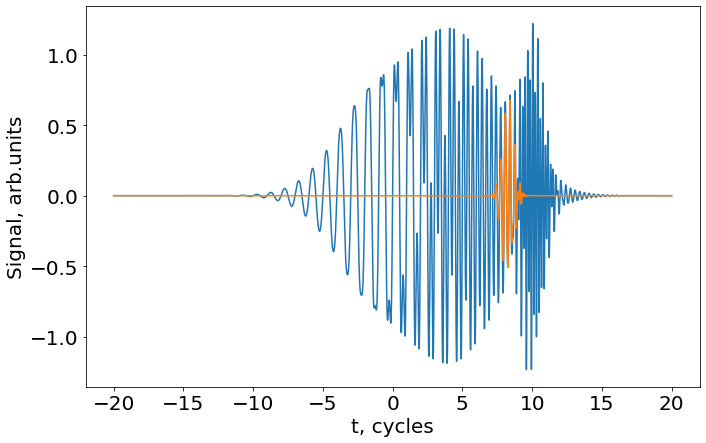

In [49]:
plt.rcParams['figure.figsize'] = (11, 7)

i = 70
window_width = (t[0] - t[-1]) / 100
window_position = np.linspace(t[0], t[-1], 100)[i]

window_function = np.exp(-(t-window_position)**2/2/window_width**2)

y_window = y * window_function

plt.plot(t/2/np.pi, y)
plt.plot(t/2/np.pi, y_window)
plt.ylabel('Signal, arb.units')
plt.xlabel('t, cycles');

In [81]:
def get_specgram(t, y, nwindowsteps=100, freq_limit=10):
    t_space = t
    window_width = (t_space[-1] - t_space[0]) / nwindowsteps
    window_positions = np.linspace(t_space[0], t_space[-1], nwindowsteps)
    w_spec = np.fft.fftfreq(len(y), d=(t_space[1]-t_space[0]) / 2 / np.pi)

    freq_limit_idx = np.where(w_spec >= freq_limit)[0][0] if freq_limit else -1
    w_spec = w_spec[:freq_limit_idx]
    
    spec_per_step = np.array([]).reshape(0, freq_limit_idx)
    for w_pos in window_positions:
        freq_values = np.zeros(w_spec.shape)
        
        window_function = np.exp(-(t_space - w_pos) ** 2 / 2 / window_width ** 2)
        y_window = y * window_function
        
        sp = np.fft.fft(y_window)
        sp = np.abs(sp) ** 2
        sp = sp[:freq_limit_idx]
        spec_per_step = np.vstack([spec_per_step, sp])
        
        ### Print only extremum values 
        # sp_idx = argrelextrema(sp, np.greater)[0]
        # for j in sp_idx:
        #     freq_values[j-5:j+6] = sp[j]
        # spec_per_step.append(freq_values)
        
    spec_per_step = np.array(spec_per_step).T
    return w_spec, spec_per_step, window_width

In [82]:
nw_step = 80

In [83]:
_, spec_per_step_3, _ = get_specgram(t, y, nw_step)
spec_per_step_3.shape, np.concatenate([spec_per_step_3, spec_per_step_3], 0).shape

((401, 80), (802, 80))

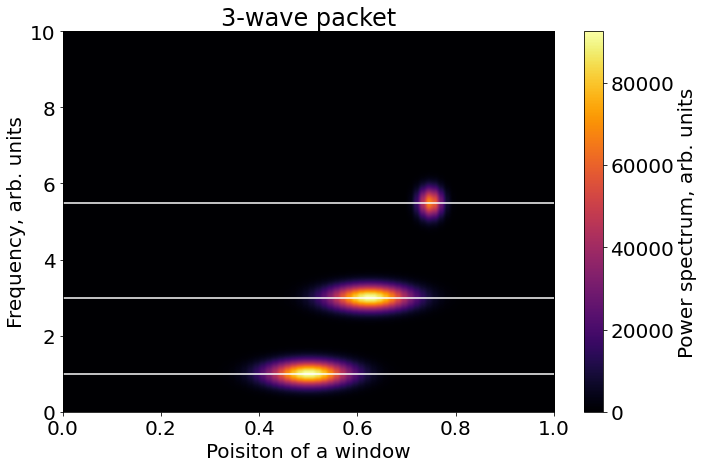

In [29]:
_, spec_per_step_3, window_width = get_specgram(t, y, nw_step)

plt.imshow(spec_per_step_3, aspect='auto', cmap='inferno', origin='lower', extent=[0, 1, 0, 10])
plt.hlines([1, 3, 5.5], [0, 0, 0], [1, 1, 1], color='w')
plt.colorbar(label='Power spectrum, arb. units')

plt.ylabel('Frequency, arb. units')
plt.xlabel('Poisiton of a window')
plt.title('3-wave packet');

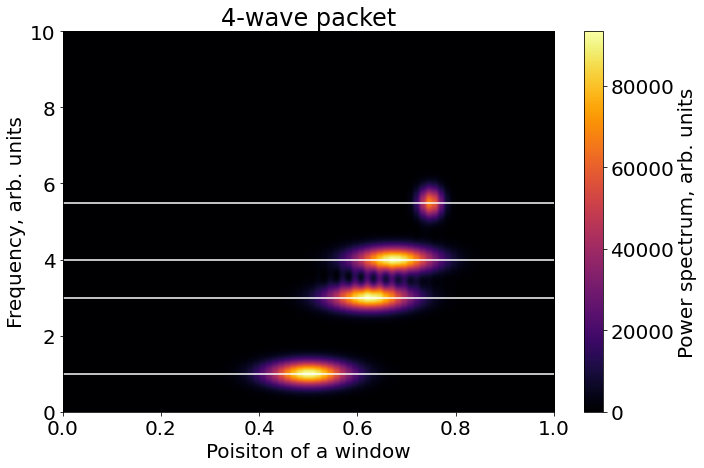

In [27]:
_, spec_per_step_4, window_width = get_specgram(t, y_4, nw_step)

plt.imshow(spec_per_step_4, aspect='auto', cmap='inferno', origin='lower', extent=[0, 1, 0, 10])
plt.hlines([1, 3, 4, 5.5], [0, 0, 0, 0], [1, 1, 1, 1], color='w')
plt.colorbar(label='Power spectrum, arb. units')

plt.ylabel('Frequency, arb. units')
plt.xlabel('Poisiton of a window')
plt.title('4-wave packet');

In [39]:
def compare_diff_timesteps(t_steps=2**14, nw_step=500):
    t = np.linspace(-20*2*np.pi, 20*2*np.pi, t_steps)

    y = np.sin(t) * np.exp(-t**2/2/20**2)
    y = y + np.sin(3*t) * np.exp(-(t-5*2*np.pi)**2/2/20**2)
    y = y + np.sin(5.5*t) * np.exp(-(t-10*2*np.pi)**2/2/5**2)
    y_4 = y + np.sin(4*t) * np.exp(-(t-7*2*np.pi)**2/2/20**2)

    w_spec, spec_per_step = get_specgram(t, y, nw_step)

    return

In [43]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**14)

418 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**14+5)

1.28 s ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**14+10)

1.27 s ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**14+25)

1.39 s ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**14+50)

612 ms ± 978 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**14+100)

1.38 s ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%%timeit -n 10 -r 7
compare_diff_timesteps(2**15)

864 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


A reason for different timings is likely the alforithm that peform the FFT under the hood. It might use powers of 2 as initial guess or something like that.